In [1]:
import xgboost as xgb
import pandas as pd
import src.train_utils as T
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.dummy import DummyRegressor

plt.style.use('ggplot')  # Try 'ggplot' as an alternative

# 1) show every column
pd.set_option('display.max_columns', None)

# 2) disable automatic expansion/wrapping
pd.set_option('display.expand_frame_repr', False)

# 3) bump the console width way up (or to None for ‘no limit’)
pd.set_option('display.width', None)

In [2]:
ds = xr.open_dataset('../datasets/exp_4_ds.nc')
mask = ds.time.dt.year < 2022
ds_excl_2022 = ds.sel(time=mask)

# 4. Convert to DataFrame
train_df = ds_excl_2022.to_dataframe().reset_index()

train_df['day_of_week'] = train_df['time'].dt.dayofweek
dow_dummies = pd.get_dummies(train_df['day_of_week'], prefix='dow')
train_df = pd.concat([train_df, dow_dummies], axis=1)

train_df['month'] = train_df['time'].dt.month
month_dummies = pd.get_dummies(train_df['month'], prefix='month')
train_df = pd.concat([train_df, month_dummies], axis=1)

train_df['is_weekend'] = train_df['time'].dt.dayofweek >= 5
train_df['is_weekend'] = train_df['is_weekend'].astype(int)


In [3]:
feature_experiments = [
    ('persistence', []),
]

model=DummyRegressor(strategy='constant', constant=0)

results = T.run_experiments(
    df=train_df, 
    model=model, 
    feature_experiments=feature_experiments, 
    train_days=365*2,
    gap_days=7*3,
    val_days=7*7
)

print(results)

  0%|          | 0/1 [00:00<?, ?it/s]

Running experiment: persistence


  0%|          | 0/10 [00:00<?, ?it/s]

    experiment  n_features  mean_rmse  mean_mae  rmse_fold_1  rmse_fold_2  rmse_fold_3  rmse_fold_4  rmse_fold_5  rmse_fold_6  rmse_fold_7  rmse_fold_8  rmse_fold_9  rmse_fold_10
0  persistence           0   4.770767   3.12517     1.783652     6.286166     5.223866     9.354229    14.504134     2.214257     1.003456     1.061782     1.985275      4.290848


In [4]:
base = ['delta_pm25_t', 'delta_pm25_t-1', 'delta_pm25_t-2', 'delta_pm25_t-3', 'pm25_t', 'u_wind_t', 'v_wind_t',
       'dew_temp_t', 'temp_t', 'surf_pressure_t', 'precip_t',
       'frp_t', 'elevation_t', 'r_humidity_t']

base += ['delta_pm25_avg_3x3', 'delta_pm25_avg_5x5', 'delta_pm25_avg_7x7', 'delta_pm25_avg_9x9']

base += ['pm25_avg_3x3', 'pm25_avg_5x5', 'pm25_avg_7x7', 'pm25_avg_9x9']

base += ['frp_max_3x3', 'frp_max_5x5', 'frp_max_7x7', 'frp_max_9x9']

base += ['frp_buffer_sum_3x3', 'frp_buffer_sum_5x5', 'frp_buffer_sum_7x7', 'frp_buffer_sum_9x9']


params = {
    'max_depth': 4,            
    'learning_rate': 0.1,     
    'n_estimators': 150,     
    'subsample': 0.8,          
    'colsample_bytree': 0.8,   
    'objective': 'reg:pseudohubererror'   
}

feature_experiments = [
    ('base', base),
    ('base + is_weekend', base + ['is_weekend']),
    ('base + day_of_week', base + ['day_of_week']),
    ('base + dow_one_hot', base + ['dow_0', 'dow_1', 'dow_2', 'dow_3', 'dow_4', 'dow_5', 'dow_6']),
    ('base + month', base + ['month']),
    ('base + month_one_hot', base + ['month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12'])
]

model=xgb.XGBRegressor(**params, random_state=191)

results = T.run_experiments(
    df=train_df, 
    model=model, 
    feature_experiments=feature_experiments, 
    train_days=365*2,
    gap_days=21,
    val_days=49
)

print(results.sort_values('mean_rmse'))

  0%|          | 0/6 [00:00<?, ?it/s]

Running experiment: base


  0%|          | 0/10 [00:00<?, ?it/s]

Running experiment: base + is_weekend


  0%|          | 0/10 [00:00<?, ?it/s]

Running experiment: base + day_of_week


  0%|          | 0/10 [00:00<?, ?it/s]

Running experiment: base + dow_one_hot


  0%|          | 0/10 [00:00<?, ?it/s]

Running experiment: base + month


  0%|          | 0/10 [00:00<?, ?it/s]

Running experiment: base + month_one_hot


  0%|          | 0/10 [00:00<?, ?it/s]

             experiment  n_features  mean_rmse  mean_mae  rmse_fold_1  rmse_fold_2  rmse_fold_3  rmse_fold_4  rmse_fold_5  rmse_fold_6  rmse_fold_7  rmse_fold_8  rmse_fold_9  rmse_fold_10
5  base + month_one_hot          42   4.221747  2.861813     1.637629     4.846499     4.975658     8.401618    12.723725     1.987511     0.907936     0.986088     1.807607      3.943198
4          base + month          31   4.230838  2.867593     1.625597     4.883335     4.965840     8.372669    12.844357     1.980262     0.907508     0.979888     1.813635      3.935289
1     base + is_weekend          31   4.248124  2.874278     1.624974     4.815865     5.023804     8.387665    12.950578     2.016352     0.905613     0.990801     1.817694      3.947898
0                  base          30   4.248382  2.882070     1.635246     4.808600     5.038874     8.413009    12.945456     1.995112     0.908033     0.986864     1.819594      3.933036
2    base + day_of_week          31   4.259099  2.882101    

          experiment  mean_rmse
  base + dow_one_hot      4.296
  base + day_of_week      4.259
                base      4.248
   base + is_weekend      4.248
        base + month      4.231
base + month_one_hot      4.222


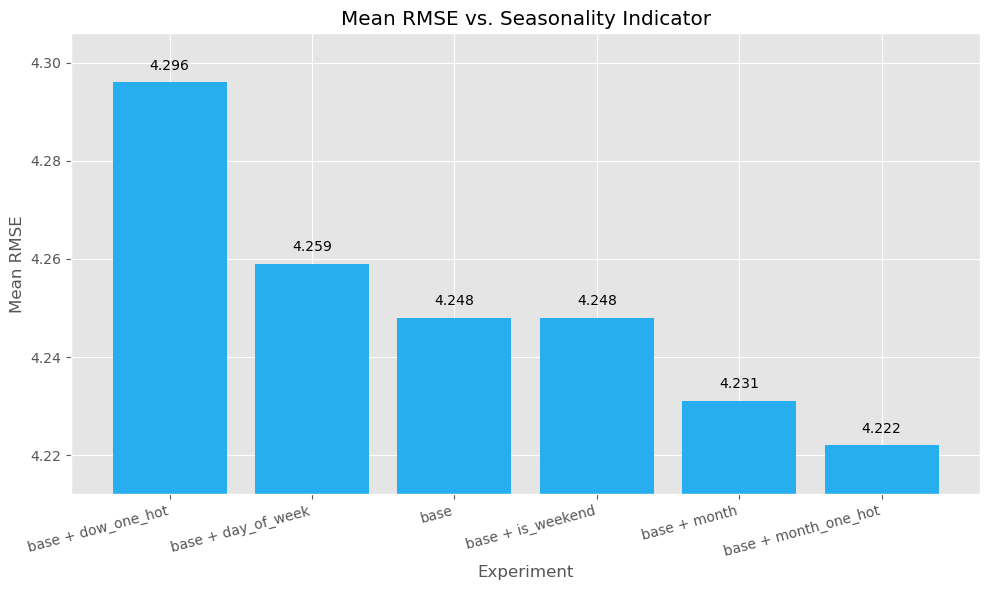

In [5]:
df = results
# Sort by mean_rmse ascending
df_sorted = df.sort_values("mean_rmse", ascending=False)

# Display the sorted DataFrame (experiment and mean_rmse)
display_df = df_sorted[["experiment", "mean_rmse"]].copy()
display_df["mean_rmse"] = display_df["mean_rmse"].round(3)

# Print the table to console
print(display_df.to_string(index=False))

# Create a bar chart of mean RMSE values, sorted
plt.figure(figsize=(10, 6))
bars = plt.bar(display_df["experiment"], display_df["mean_rmse"], color='#27aeef')
plt.ylim(display_df["mean_rmse"].min() - 0.01, display_df["mean_rmse"].max() + 0.01)
plt.xticks(rotation=15, ha="right")
plt.xlabel("Experiment", fontsize=12)
plt.ylabel("Mean RMSE", fontsize=12)

# Annotate each bar with its exact mean value
for bar, mean in zip(bars, display_df["mean_rmse"]):
    y = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, y + 0.002, f"{mean:.3f}", 
             ha='center', va='bottom', fontsize=10)

plt.title('Mean RMSE vs. Seasonality Indicator')
plt.tight_layout()
plt.show()

In [14]:
base = ['delta_pm25_t', 'delta_pm25_t-1', 'delta_pm25_t-2', 'delta_pm25_t-3', 'pm25_t', 'u_wind_t', 'v_wind_t',
       'dew_temp_t', 'temp_t', 'surf_pressure_t', 'precip_t',
       'frp_t', 'elevation_t', 'r_humidity_t']

base += ['delta_pm25_avg_3x3', 'delta_pm25_avg_5x5', 'delta_pm25_avg_7x7', 'delta_pm25_avg_9x9']

base += ['pm25_avg_3x3', 'pm25_avg_5x5', 'pm25_avg_7x7', 'pm25_avg_9x9']

base += ['frp_max_3x3', 'frp_max_5x5', 'frp_max_7x7', 'frp_max_9x9']

base += ['frp_buffer_sum_3x3', 'frp_buffer_sum_5x5', 'frp_buffer_sum_7x7', 'frp_buffer_sum_9x9']


params = {
    'max_depth': 4,            
    'learning_rate': 0.1,     
    'n_estimators': 150,     
    'subsample': 0.8,          
    'colsample_bytree': 0.8,   
    'objective': 'reg:pseudohubererror'   
}

feature_experiments = [
    ('base + burn season', base + ['month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_11', 'month_12']),
    ('base + month_one_hot', base + ['month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12'])
]

model=xgb.XGBRegressor(**params, random_state=191)

results = T.run_experiments(
    df=train_df, 
    model=model, 
    feature_experiments=feature_experiments, 
    train_days=365*2,
    gap_days=21,
    val_days=49
)

print(results.sort_values('mean_rmse'))

  0%|          | 0/2 [00:00<?, ?it/s]

Running experiment: base + burn season


  0%|          | 0/10 [00:00<?, ?it/s]

Running experiment: base + month_one_hot


  0%|          | 0/10 [00:00<?, ?it/s]

             experiment  n_features  mean_rmse  mean_mae  rmse_fold_1  rmse_fold_2  rmse_fold_3  rmse_fold_4  rmse_fold_5  rmse_fold_6  rmse_fold_7  rmse_fold_8  rmse_fold_9  rmse_fold_10
1  base + month_one_hot          42   4.221747  2.861813     1.637629     4.846499     4.975658     8.401618    12.723725     1.987511     0.907936     0.986088     1.807607      3.943198
0    base + burn season          37   4.236164  2.872558     1.632492     4.822143     5.019202     8.404433    12.848427     1.976584     0.906787     0.981022     1.813469      3.957085


In [6]:
# (1) Get the month numbers (1–12) for each time step:
months = ds['time'].dt.month

# (2) Loop over all twelve months and create a new variable for each:
for m in range(1, 13):
    ds[f"month_{m:02d}"] = (months == m).astype(int)

In [15]:
ds.to_dataframe()

pm25_t  u_wind_t  v_wind_t  dew_temp_t      temp_t  surf_pressure_t      precip_t  frp_t  elevation_t  delta_pm25_t+1  delta_pm25_t  r_humidity_t  delta_pm25_t-1  delta_pm25_t-2  delta_pm25_t-3  delta_pm25_avg_3x3  delta_pm25_avg_5x5  delta_pm25_avg_7x7  delta_pm25_avg_9x9  pm25_avg_3x3  pm25_avg_5x5  pm25_avg_7x7  pm25_avg_9x9  frp_max_3x3  frp_max_5x5  frp_max_7x7  frp_max_9x9  frp_sum_3x3  frp_sum_5x5  frp_sum_7x7  frp_sum_9x9  frp_buffer_sum_3x3  frp_buffer_sum_5x5  frp_buffer_sum_7x7  frp_buffer_sum_9x9  month_01  month_02  month_03  month_04  month_05  month_06  month_07  month_08  month_09  month_10  month_11  month_12
time       i  j                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
2018-07-08 0  0    9.513633  1.040234  0.047216  291.942383  293.100189     85344.046875  1.115932e-02    0.0       1360.0       -0.491020      0.556278     98.281067        0.038002        0.601407        0.302968            0.789314            0.734057            0.640796            0.702518      9.580145      9.402309      9.308264      9.289756          0.0          0.0     0.000000     0.000000          0.0          0.0     0.000000     0.000000                 0.0                 0.0            0.000000            0.000000         0         0         0         0         0         0         1         0         0         0         0         0
              1    8.694135  0.926424  0.103043  292.972748  294.421875     87667.421875  1.054819e-02    0.0       1189.0        0.339427      0.060918     97.862534        1.064866       -1.001619        0.522349            0.631020            0.626528            0.657130            0.674091      9.348599      9.319261      9.280797      9.243377          0.0          0.0     0.000000     0.000000          0.0          0.0     0.000000     0.000000                 0.0                 0.0            0.000000            0.000000         0         0         0         0         0         0         1         0         0         0         0         0
              2    8.702046  0.784416  0.177018  293.667633  295.682129     89480.257812  9.948850e-03    0.0        975.0        0.625493      0.058055     97.051796        0.587489       -1.125940        0.973524            0.349193            0.602640            0.585718            0.532589      9.044597      9.259371      9.189150      9.094057          0.0          0.0     0.000000     0.000000          0.0          0.0     0.000000     0.000000                 0.0                 0.0            0.000000            0.000000         0         0         0         0         0         0         1         0         0         0         0         0
              3    8.956724  0.609245  0.260147  293.460449  295.622559     89063.468750  9.994119e-03    0.0       1005.0        0.176971      0.167542     96.837585        0.669046       -0.095932       -0.419762            0.292146            0.400938            0.429089            0.381801      8.920217      9.014485      9.028864      8.922835          0.0          0.0     0.000000     0.000000          0.0          0.0     0.000000     0.000000                 0.0                 0.0            0.000000            0.000000         0         0         0         0         0         0         1         0         0         0         0         0
              4    8.738454  0.311515  0.377131  293.645172  295.106354     88635.007812  1

In [16]:
ds.to_netcdf(
    "exp_5_ds.nc",
    format="NETCDF4",       # HDF5-backed NetCDF
    engine="netcdf4",      # or "netcdf4" if you have that
    encoding={
        var: {
            "zlib": True,
            "complevel": 4,
        }
        for var in ds.data_vars
    }
)